Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'D:/Libraries/Documents/Tensorflow/notMNIST_data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (300000, 28, 28) (300000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (300000, 784) (300000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [9]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [14]:
train_labels = train_labels.squeeze()
valid_labels = valid_labels.squeeze()
test_labels = test_labels.squeeze()

We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [10]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [6]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [11]:
num_steps = 3001

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  

Initialized
Loss at step 0: 17.154507
Training accuracy: 8.6%
Validation accuracy: 11.4%
Loss at step 100: 2.357708
Training accuracy: 72.0%
Validation accuracy: 71.2%
Loss at step 200: 1.890548
Training accuracy: 74.8%
Validation accuracy: 73.9%
Loss at step 300: 1.635519
Training accuracy: 75.6%
Validation accuracy: 74.6%
Loss at step 400: 1.465770
Training accuracy: 76.4%
Validation accuracy: 75.0%
Loss at step 500: 1.341198
Training accuracy: 77.2%
Validation accuracy: 75.3%
Loss at step 600: 1.244038
Training accuracy: 77.8%
Validation accuracy: 75.5%
Loss at step 700: 1.165256
Training accuracy: 78.5%
Validation accuracy: 75.6%
Loss at step 800: 1.099731
Training accuracy: 78.9%
Validation accuracy: 75.8%
Loss at step 900: 1.044171
Training accuracy: 79.3%
Validation accuracy: 75.9%
Loss at step 1000: 0.996301
Training accuracy: 79.8%
Validation accuracy: 76.0%
Loss at step 1100: 0.954520
Training accuracy: 80.1%
Validation accuracy: 76.2%
Loss at step 1200: 0.917674
Training acc

Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [13]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [15]:
num_steps = 30001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  single_layer_weights = weights.eval()

Initialized
Minibatch loss at step 0: 17.302416
Minibatch accuracy: 9.4%
Validation accuracy: 12.2%
Minibatch loss at step 500: 1.606239
Minibatch accuracy: 74.2%
Validation accuracy: 75.5%
Minibatch loss at step 1000: 1.498335
Minibatch accuracy: 79.7%
Validation accuracy: 76.8%
Minibatch loss at step 1500: 1.115112
Minibatch accuracy: 82.0%
Validation accuracy: 77.6%
Minibatch loss at step 2000: 0.971741
Minibatch accuracy: 80.5%
Validation accuracy: 78.2%
Minibatch loss at step 2500: 1.235459
Minibatch accuracy: 74.2%
Validation accuracy: 78.7%
Minibatch loss at step 3000: 0.776219
Minibatch accuracy: 80.5%
Validation accuracy: 79.7%
Minibatch loss at step 3500: 1.145633
Minibatch accuracy: 74.2%
Validation accuracy: 79.4%
Minibatch loss at step 4000: 0.933193
Minibatch accuracy: 83.6%
Validation accuracy: 80.0%
Minibatch loss at step 4500: 0.838143
Minibatch accuracy: 85.2%
Validation accuracy: 80.1%
Minibatch loss at step 5000: 0.869230
Minibatch accuracy: 76.6%
Validation accurac

---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [16]:
batch_size = 128
num_hidden_nodes = 1024


graph = tf.Graph()
with graph.as_default():
    
    #Constant Testing and Validation Data
    tf_test_data = tf.constant(test_dataset)
    tf_valid_data = tf.constant(valid_dataset)
    
    #Batch input training data for stochastic gradient descent
    tf_training_data = tf.placeholder(dtype=tf.float32,shape=(batch_size, image_size*image_size))
    tf_training_labels = tf.placeholder(dtype=tf.float32,shape=(batch_size,num_labels))
    
    #Variable weights to be optimized. Two layers
    weights1 = tf.Variable(tf.truncated_normal([image_size*image_size,num_hidden_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes,num_labels]))
    biases1 = tf.Variable(tf.zeros(num_hidden_nodes))
    biases2 = tf.Variable(tf.zeros(num_labels))
    
    
    #Creating graph structure
    hidden_layer_out = tf.nn.relu(tf.matmul(tf_training_data, weights1)+biases1)
    logits = tf.matmul(hidden_layer_out,weights2)+biases2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=tf_training_labels))
    
    #Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss=loss)
    
    #Output predictions
    tf_train_preds = tf.nn.softmax(logits)
    tf_test_preds = tf.nn.softmax(tf.matmul(tf.nn.relu(
        tf.matmul(tf_test_data,weights1)+biases1),weights2)+biases2)
    tf_valid_preds = tf.nn.softmax(tf.matmul(tf.nn.relu(
        tf.matmul(tf_valid_data,weights1)+biases1),weights2)+biases2)
    




Now we run the session

In [21]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    for step in range(num_steps):
        #not the best randomization once you have >1 epoch, but works
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        #generate batches
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :].squeeze()
        
        #create feed-dictionary
        feed_dict = {tf_training_data: batch_data, tf_training_labels: batch_labels}
        
        #run session
        _, l, predictions = session.run([optimizer, loss, tf_train_preds], feed_dict=feed_dict)
        if (step % 5000 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
            tf_valid_preds.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(tf_test_preds.eval(), test_labels))
        
        

Minibatch loss at step 0: 320.553345
Minibatch accuracy: 5.5%
Validation accuracy: 31.6%
Minibatch loss at step 5000: 1.267570
Minibatch accuracy: 82.8%
Validation accuracy: 83.9%
Minibatch loss at step 10000: 0.951487
Minibatch accuracy: 85.2%
Validation accuracy: 84.6%
Minibatch loss at step 15000: 0.571754
Minibatch accuracy: 87.5%
Validation accuracy: 85.6%
Minibatch loss at step 20000: 1.040916
Minibatch accuracy: 88.3%
Validation accuracy: 86.5%
Minibatch loss at step 25000: 0.561510
Minibatch accuracy: 91.4%
Validation accuracy: 86.7%
Minibatch loss at step 30000: 0.578272
Minibatch accuracy: 85.9%
Validation accuracy: 87.0%
Minibatch loss at step 35000: 0.511266
Minibatch accuracy: 87.5%
Validation accuracy: 87.0%
Minibatch loss at step 40000: 0.179788
Minibatch accuracy: 93.0%
Validation accuracy: 87.3%
Minibatch loss at step 45000: 0.191783
Minibatch accuracy: 93.0%
Validation accuracy: 87.6%
Minibatch loss at step 50000: 0.133431
Minibatch accuracy: 93.8%
Validation accuracy

Doing some visualization to try to see the networks

(784, 10)
0


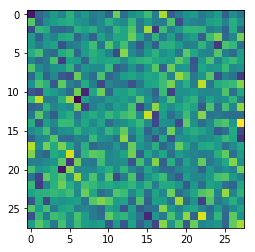

1


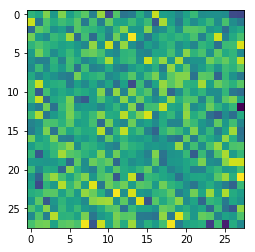

2


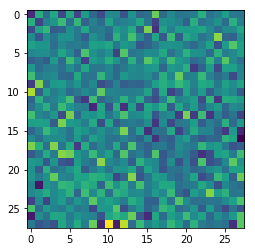

3


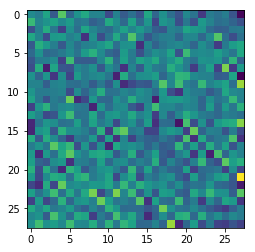

4


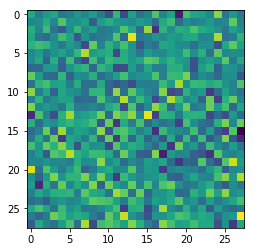

5


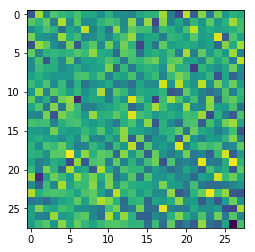

6


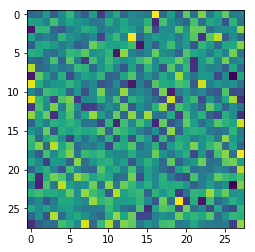

7


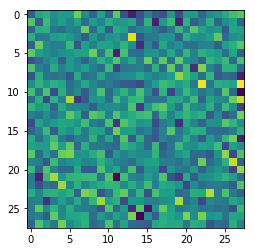

8


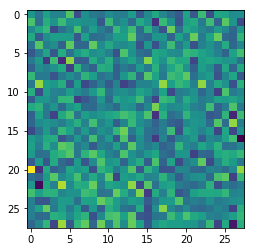

9


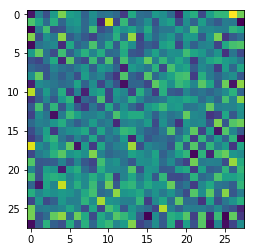

In [19]:
import matplotlib.pyplot as plt
single_layer_weights
logweights = 1/(1+np.exp(np.negative(single_layer_weights)))
print(logweights.shape)
for i in range(10):
    print(i)
    weights_i = np.resize(logweights[:,i:i+1],[image_size,image_size])
    plt.imshow(weights_i)
    plt.show()
